In [1]:
import sys
import collections
import itertools
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform
import math

plt.style.use('bmh')
%matplotlib inline

def dtw_distance(ts_1, ts_2):    
     #ts_1: time serie 1 
     #ts_2: time serie 2

    distance, path = fastdtw(ts_1, ts_2, dist=euclidean)
    return distance

### Calculate and visualize distance btw 2 series

Text(0, 0.5, 'Amplitude')

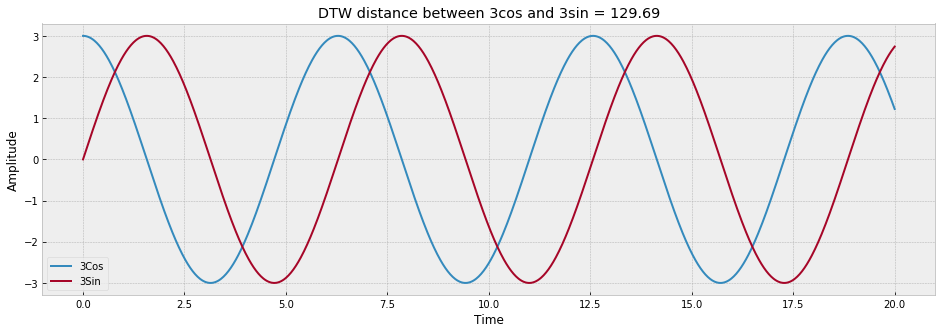

In [2]:
# Test time series

# Make look noice
plt.rcParams["figure.figsize"] = [16,5]


x = np.linspace(0, 20, 1000)
ycos3 = np.array([3*math.cos(x) for x in x])
ysin3 = np.array([3*math.sin(x) for x in x])

plt.plot(x, ycos3, label='3Cos')
plt.plot(x, ysin3, label='3Sin')
plt.legend()

plt.title( "DTW distance between 3cos and 3sin = {0:.2f}".format(dtw_distance(ysin3, ycos3) ) )

plt.xlabel('Time')
plt.ylabel('Amplitude')

### Test dist_matrix function

In [3]:
def dist_matrix(x, y):
    '''x, y are 2 arrays contains many time series '''
    x_s = np.shape(x)
    y_s = np.shape(y)
    dm = np.zeros((x_s[0], y_s[0])) 
    dm_size = x_s[0]*y_s[0]

    print('Calculating dist_matrix, this may take a while.')
    for i in range(x_s[0]):
        for j in range(y_s[0]):
#             print('Distance of {0} and {1}'.format(i, j))
            print('.',end='')
            dm[i][j] = dtw_distance(x[i], y[j])

    print('\nAll done.')
    return dm

In [4]:
array1 = np.random.random((4,50))
array2 = np.random.random((4,50))
print(dist_matrix(array1,array2))


Calculating dist_matrix, this may take a while.
................
All done.
[[11.9639725  10.67717231  9.6955919   9.79551411]
 [10.45394137 10.28244932 10.72642688 10.76460362]
 [ 9.08259942 10.15810075 10.63392295 10.12616156]
 [ 8.58035026  9.95875875  8.74550518  9.28429092]]


## Human Activity Recognition Dataset

In [5]:
# Import the HAR dataset
x_train_file = open('data/X_train.txt', 'r')
y_train_file = open('data/y_train.txt', 'r')

x_test_file = open('data/X_test.txt', 'r')
y_test_file = open('data/y_test.txt', 'r')

x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

#### Visualizing sample activities from the HAR dataset

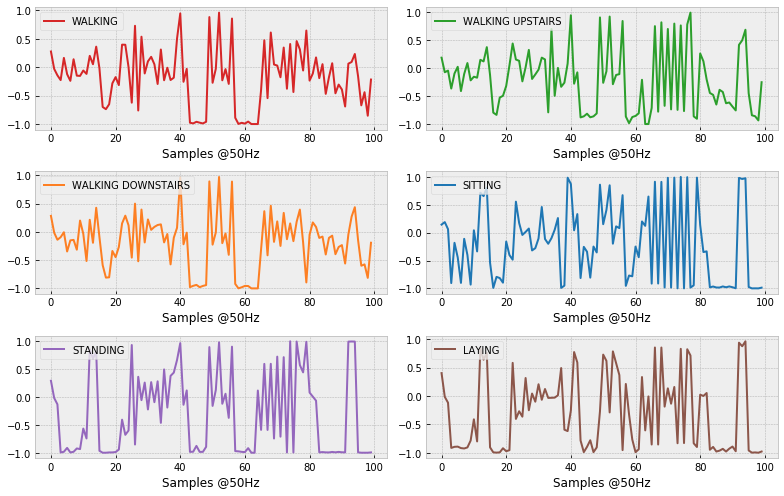

In [6]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for l in labels:
    # Get first indexes of iteration label
    y_idx = np.where(y_train == l)[0][0]
    plt.subplot(3, 2, l)
    plt.plot(x_train[y_idx][:100], label = labels[l], color=colors[l-1], linewidth = 2)
    plt.xlabel('Samples @50Hz')
    plt.tight_layout()
    plt.legend(loc='upper left')


### Implement KNN classification

In [7]:
x_train.shape

(90, 561)

In [8]:
x_test.shape

(8, 561)

In [19]:
class KNN(object):
    
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, x, l):
        self.training_x = x
        self.training_label = l

    def predict(self, x):
        dm = dist_matrix(x, self.training_x)
        
        resulting_labels = []
        resulting_probs = []

        
        # For each row... (each test sample)
        for i in range(len(dm)):
            row = dm[i]
            sorted_indices = np.argsort(row)
#             sorted_dm = np.argpartition(dm, self.n_neighbors, axis=1)

            # List of the labels corresponding to the closest n labels
            neighbor_labels = []
            
            # For each closest neighbour (use sorted indices of row to determine closest n)
            for n in range(self.n_neighbors):
                # Add the training label that corresponds to the closest (DTM) training sample
                # to this test sample. (This row)
                
                # Use np where and index [0][0] as func returns 
                corresponding_index = sorted_indices[n]
                this_neighbor = self.training_label[corresponding_index]
                neighbor_labels.append(this_neighbor)

            # Predict this sample (this row) as the same label that most of its n nearest neighbors...
            
            # Mode data, returns most occuring label and it's count
            mode_data = mode(neighbor_labels)
            
            # Most occuring label
            mode_label = mode_data[0][0]
            
            # Probability is the ratio of neighbors that had the most occuring labels vs. othewise
            mode_proba = mode_data[1][0]/self.n_neighbors
            
            # Append this samples results to the resulting_labels/probs lists
            resulting_labels.append(mode_label)
            resulting_probs.append(mode_proba)
            
        # After going through each sample, return result lists
        return resulting_labels, resulting_probs


In [20]:
m = KNN(n_neighbors=1)
m.fit(x_train, y_train)
label, proba = m.predict(x_test)

Calculating dist_matrix, this may take a while.
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
All done.


In [21]:
label

[5, 5, 6, 2, 3, 1, 2, 2]

In [22]:
proba

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [23]:
y_test

array([5, 4, 6, 1, 3, 3, 2, 2])

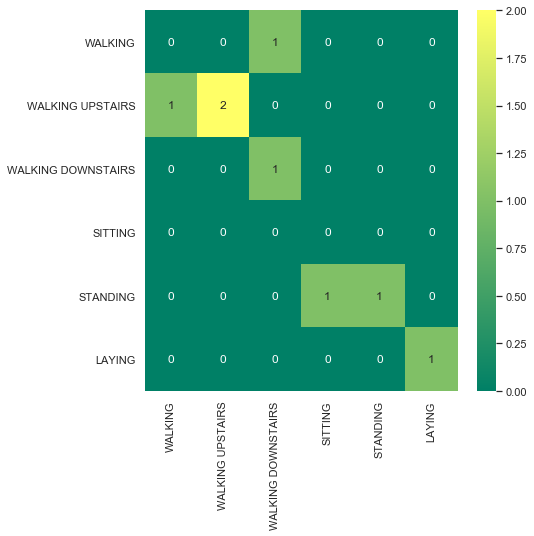

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(label, y_test)
sns.set()
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True, ax=ax, cmap="summer", yticklabels = labels.values(), xticklabels=labels.values())

plt.show()